In [18]:
import string
import numpy as np
import pandas as pd
import os
# Visualizations
import matplotlib.pyplot as plt
import torchvision.transforms as transforms  # contains a collection of transformations
import torch
import torch.nn.functional as F
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset  # For training data and data processing
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# Hyper-parameters and some variables for data processing
batch = 128
lr = 0.01
input_size = (28, 28)
n_classes = 26
valid_percent = 0.2

# # Checking whether GPU is working
# train_on_gpu = torch.cuda.is_available()
# print(f'Train on gpu: {train_on_gpu}')
save_model_path = 'model-output.pt'
checkpoint_path = 'checkpoint.pth'

In [20]:
# Loading dataset
mn_test_set = pd.read_csv('./drive/MyDrive/csc413_project_data/sign_mnist_test.csv')
mn_train_set = pd.read_csv('./drive/MyDrive/csc413_project_data/sign_mnist_train.csv')

In [21]:
# Converting dataset into numpy (split sample data and target at the same time)
test_t = mn_test_set.label.to_numpy()
test_sam = mn_test_set.loc[:, mn_test_set.columns != 'label'].to_numpy()
test_sam = test_sam.reshape((test_sam.shape[0], 1, input_size[0], input_size[1]))
train_t = mn_train_set.label.to_numpy()
train_sam = mn_train_set.loc[:, mn_train_set.columns != 'label'].to_numpy()
train_sam = train_sam.reshape((train_sam.shape[0], 1, input_size[0], input_size[1]))

# Now converting numpy to tensor and construct a TensorDataset for Pytorch training
train_dat = TensorDataset(torch.tensor(train_sam, dtype=torch.float32),
                           torch.tensor(train_t, dtype=torch.long))
test_dat = TensorDataset(torch.tensor(test_sam, dtype=torch.float32),
                          torch.tensor(test_t, dtype=torch.long))

In [22]:
# Split train_data into training set and validation set
train_data_size = train_dat.tensors[0].shape[0]  # number of rows in sample tensor of train_data
valid_size = int(train_data_size * valid_percent)
train_ds, val_ds = torch.utils.data.random_split(train_dat, [train_data_size - valid_size, valid_size])

In [23]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=128 * 5 * 5, out_features=128, bias=True),
            nn.ReLU(),
            # nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=128, out_features=64, bias=True),
            nn.ReLU(),
            # nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=64, out_features=n_classes, bias=True),
            nn.LogSoftmax(dim=1)
        )

    def extract_features(self, x):
      x = self.cnn_layers(x)
      x = F.avg_pool2d(x, x.size()[2:])
      x = x.reshape(x.size()[0], -1)
      return x

    def forward(self, x):
      x = self.cnn_layers(x)
      x = x.view(x.size()[0], -1)
      x = self.classifier(x)
      return x

In [25]:
def train_model(model, train_dataset, val_dataset, save_file_name=save_model_path, learning_rate=lr,
                batch_size=batch, num_epochs=20, early_return=3):
    train_ld = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_ld = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # if train_on_gpu:
    #     model = model.cuda()
    #     criterion = criterion.cuda()

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Training loop
    for epoch in range(num_epochs):
        print(f'Training Epoch {epoch}...\n')
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        model.train()
        for i, (imgs, labels) in enumerate(train_ld):
            # print(f'Data shape: {imgs.shape}\n')
            # if train_on_gpu:
            #     imgs, labels = imgs.cuda(), labels.cuda()
            # Clear gradients
            optimizer.zero_grad()
            output = model(imgs)


            # Calculating loss
            loss = criterion(output, labels)
            loss.backward()

            # Update param.
            optimizer.step()

            # Calculating train loss
            train_loss += loss.item() * imgs.size(0)

            # Calculating accuracy
            _, pred = torch.max(output, dim=1)
            correct = pred.eq(labels.data.view_as(pred))
            accuracy = torch.mean(correct.type(torch.FloatTensor))
            train_acc += accuracy.item() * imgs.size(0)

        with torch.no_grad():
            model.eval()

            for imgs, labels in val_ld:
                # if train_on_gpu:
                #     imgs, labels = imgs.cuda(), labels.cuda()

                # Forward pass
                output = model(imgs)

                # compute loss
                loss = criterion(output, labels)
                valid_loss += loss.item() * imgs.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(labels.data.view_as(pred))
                accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * imgs.size(0)

            # Compute average loss and accuracy
            train_loss = train_loss / len(train_ld.dataset)
            valid_loss = valid_loss / len(val_ld.dataset)
            train_acc = train_acc / len(train_ld.dataset)
            valid_acc = valid_acc / len(val_ld.dataset)

            # Record the result of this epoch
            history.append([train_loss, valid_loss, train_acc, valid_acc])

            print(f'Epoch: {epoch} \tTrain Loss: {train_loss:.4f} '
                  f'\tValidation Loss: {valid_loss:.4f}')
            print(
                f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t '
                f'Validation Accuracy: {100 * valid_acc:.2f}%\n'
            )

            # Early return detection
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                valid_loss_min = valid_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

                if epochs_no_improve >= early_return:
                    print(f'Early return at epoch {epoch} with lowest loss {valid_loss_min}!\n')
                    # Early return, then reload the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Record the state of optimizer which helps to save the model
                    model.optimizer = optimizer
                    # Re-construct history to a Dataframe which easy to plot
                    history = pd.DataFrame(history,
                                           columns=['train_loss', 'valid_loss',
                                                    'train_acc', 'valid_acc'])
    return model

In [26]:
cnn_model = CNN()
cnn_model= train_model(cnn_model, train_ds, val_ds, num_epochs=3)

Training Epoch 0...

Epoch: 0 	Train Loss: 8.6813 	Validation Loss: 1.8088
		Training Accuracy: 15.66%	 Validation Accuracy: 42.25%

Training Epoch 1...

Epoch: 1 	Train Loss: 1.1035 	Validation Loss: 0.5657
		Training Accuracy: 62.13%	 Validation Accuracy: 80.48%

Training Epoch 2...

Epoch: 2 	Train Loss: 0.4916 	Validation Loss: 0.4125
		Training Accuracy: 82.88%	 Validation Accuracy: 85.16%



In [27]:
!pip install pytube
!pip install tensorflow

In [28]:
import json
import numpy as np
from pytube import YouTube, exceptions
from math import ceil
import os
import cv2
import gc
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Masking, Input, Dropout, BatchNormalization

In [29]:
def load_json(file_name):
    with open(file_name, 'r') as file:
        return json.load(file)

def load_data(path):
  with open(path, 'r') as file:
        data = json.load(file)
  filtered_data = [item for item in data if item['clean_text'] in classes.keys()]
  # print(len(filtered_data))
  for item in filtered_data:
      item['url'] = 'w' + item['url'].lstrip('https://www.youtube.com')
  return filtered_data

def download_video(url, output_path, filename):
    """Downloads a video from YouTube."""

    file_path = os.path.join(output_path, filename)
    # Skip download if file already exist
    if os.path.exists(file_path):
        return file_path

    try:
        yt = YouTube(url)
        stream = yt.streams.get_highest_resolution()
        stream.download(output_path=output_path, filename=filename)
        return file_path
    except exceptions.VideoPrivate:
        return None
    except exceptions.VideoUnavailable:
        return None
    except Exception as e:
        return None

In [30]:
classes_data = load_json('./drive/MyDrive/csc413_project_data/MSASL_classes.json')
classes = {word: idx for idx, word in enumerate(classes_data[:10])}

train_data = load_data('./drive/MyDrive/csc413_project_data/MSASL_train.json')
test_data = load_data('./drive/MyDrive/csc413_project_data/MSASL_test.json')
val_data = load_data('./drive/MyDrive/csc413_project_data/MSASL_val.json')

In [31]:
def extract_and_preprocess_frames(url, start_time, end_time, fps, box, width, height, frame_skip=2, resize_dim=(128, 128)):
    local_video_path = download_video('https://www.youtube.com/' + url, './videos', url.split("=")[1] + '.mp4')
    if local_video_path is None:
        return None

    video = cv2.VideoCapture(local_video_path)
    frames_to_skip = int(fps / frame_skip)
    frames = []
    current_frame = 0

    video.set(cv2.CAP_PROP_POS_MSEC, start_time * 1000)

    while True:
        ret, frame = video.read()
        if not ret:
            break
        if current_frame % frames_to_skip == 0:
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            x_min = int(box[0] * width)
            y_min = int(box[1] * height)
            x_max = int(box[2] * width)
            y_max = int(box[3] * height)
            cropped_frame = gray_frame[y_min:y_max, x_min:x_max]
            resized_frame = cv2.resize(cropped_frame, resize_dim)
            normalized_frame = resized_frame.astype(np.float32) / 255.0
            frames.append(normalized_frame)
        current_frame += 1

    return frames

def pad_sequences(sequences, maxlen=None, dtype='float32', padding='post', value=0.0):
    if not sequences:  # Check if sequences list is empty
        return np.array([])  # Return an empty numpy array if no sequences to pad

    # Attempt to get the feature size safely
    try:
        feature_size = sequences[0].shape[1]
    except (IndexError, AttributeError):
        # Handle the case where sequences[0] does not exist or does not have a second dimension
        return np.array([])

    if not maxlen:
        maxlen = max(len(x) for x in sequences if x is not None)

    # Initialize the padded sequences with the correct shape
    padded_sequences = np.full((len(sequences), maxlen, feature_size), value, dtype=dtype)

    # Copy sequences into the padded array
    for idx, sequence in enumerate(sequences):
        if sequence is not None:  # Make sure the sequence is not None
            sequence_length = min(len(sequence), maxlen)  # Handle sequences longer than maxlen
            if padding == 'post':
                padded_sequences[idx, :sequence_length] = sequence[:sequence_length]
            elif padding == 'pre':
                padded_sequences[idx, -sequence_length:] = sequence[:sequence_length]

    return padded_sequences

def load_and_preprocess_image(frame):
    img = image.img_to_array(frame)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def extract_features(video_data, cnn_model):
    frames = extract_and_preprocess_frames(video_data['url'], video_data['start_time'],
                                           video_data['end_time'], video_data['fps'],
                                           video_data['box'], video_data['width'], video_data['height'])
    if frames is None or len(frames) == 0:
        return np.array([])

    with torch.no_grad():
      # Convert list of frames to a batch for efficient processing
      batch_frames = np.array([load_and_preprocess_image(frame) for frame in frames])
      batch_frames = np.vstack(batch_frames)  # Shape: (num_frames, height, width, channels)
      batch_frames = batch_frames.transpose((0, 3, 1, 2))  # Shape: (num_frames, channels, height, width)
      batch_frames = torch.tensor(batch_frames, dtype=torch.float32)  # Shape: (num_frames, channels, height, width)
      # if torch.cuda.is_available():
      #   batch_frames = batch_frames.cuda()
      # print(batch_frames.shape)
      features = cnn_model.extract_features(batch_frames)
      features = np.array(features)
      # print(features.shape)
      # if torch.cuda.is_available():
      #   features = features.cpu()  # Move to CPU if on GPU
      # features = features.numpy()
    return features

def batch_and_process(data, cnn_model, rnn_model, batch_size=5):
    batch = []
    for video_data in data:
        features = extract_features(video_data, cnn_model)
        # print(f"Features extracted for video {video_data['url']}")
        if features is not None and features.size > 0:
            batch.append({'label': video_data['label'], 'features': features})
        else:
            continue
            # print(f"Features could not be extracted for video {video_data['url']}")

        if len(batch) == batch_size:
            max_len = max(len(item['features']) for item in batch)
            batch_features = pad_sequences([item['features'] for item in batch], maxlen=max_len)
            batch_labels = np.array([item['label'] for item in batch])
            yield batch_features, batch_labels
            del batch_features, batch_labels, batch[:]
            gc.collect()
            batch = []

    if batch:
        max_len = max(len(item['features']) for item in batch)
        batch_features = pad_sequences([item['features'] for item in batch], maxlen=max_len)
        batch_labels = np.array([item['label'] for item in batch])
        yield batch_features, batch_labels
        del batch_features, batch_labels, batch[:]
        gc.collect()

In [32]:
def sparse_categorical_crossentropy(true_labels, predictions, probs):
    """ Calculate sparse categorical crossentropy loss manually. """
    # Convert predictions to probability distributions using one-hot encoding
    num_classes = np.max(true_labels) + 1
    true_dist = np.eye(num_classes)[true_labels]
    # Sparse Categorical Crossentropy calculation
    return -np.sum(true_dist * np.log(probs + 1e-15)) / len(true_labels)

def evaluate_model(cnn_model, rnn_model, data):
    """Evaluate the model on given data without using .evaluate method."""
    all_features = []
    all_labels = []
    predictions = []
    true_labels = []
    for video_data in data:
        features = extract_features(video_data, cnn_model)
        if features.size > 0:
            all_features.append(features)
            all_labels.append(video_data['label'])

    # If no valid data was found, return an error message or zero accuracy
    if not all_features:
        return 0.0, 0.0

    # Pad the sequences for RNN processing
    max_len = max(len(features) for features in all_features)
    all_features_padded = pad_sequences(all_features, maxlen=max_len)
    all_labels = np.array(all_labels)

    # Predict the model output
    predicted_probs = rnn_model.predict(all_features_padded, verbose=0)
    predicted_labels = np.argmax(predicted_probs, axis=1)

    # Extend predictions and true labels
    predictions.extend(predicted_labels)
    true_labels.extend(all_labels)

    # Calculate confusion matrix and plot it
    cm = confusion_matrix(true_labels, predictions)
    plot_confusion_matrix(cm, np.unique(all_labels), 'Validation')

    # Calculate the accuracy
    accuracy = accuracy_score(true_labels, predictions)

    # Calculate the loss using sparse categorical crossentropy
    loss = sparse_categorical_crossentropy(true_labels, predicted_labels, predicted_probs)

    return loss, accuracy

In [33]:
def plot_confusion_matrix(cm, class_names, dataset_type):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'{dataset_type} Confusion Matrix')
    plt.show()

In [34]:
def create_rnn(num_classes):
    input_layer = Input(shape=(None, 128))
    masked_input = Masking(mask_value=0.0)(input_layer)
    lstm_layer = LSTM(64, return_sequences=True)(masked_input)
    norm_layer1 = BatchNormalization()(lstm_layer)
    lstm_layer = LSTM(64)(norm_layer1)
    norm_layer2 = BatchNormalization()(lstm_layer)
    dense_layer = Dense(64, activation='relu')(norm_layer2)
    output_layer = Dense(num_classes, activation='softmax')(dense_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# if tf.config.list_physical_devices('GPU'):
#   device_tf = '/GPU:0'
# else:
#   device_tf = '/CPU:0'
# with tf.device(device_tf):
rnn_model = create_rnn(len(classes))

In [35]:
def train_rnn_model(cnn_model, rnn_model, train_data, val_data, test_data, epochs=10, batch_size=5):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        batch_idx = 0
        for batch_features, batch_labels in batch_and_process(train_data, cnn_model, rnn_model, batch_size):
            # print(f"START BATCH {batch_idx}")
            rnn_model.train_on_batch(batch_features, batch_labels)
            # print(f"END BATCH {batch_idx}")  # progress indicator
            batch_idx += 1
        val_loss, val_accuracy = evaluate_model(cnn_model, rnn_model, val_data)
        print(f"Validation loss: {val_loss}, Accuracy: {val_accuracy}")
        print(f"END Epoch {epoch+1}")
        K.clear_session()
        gc.collect()
    test_loss, test_accuracy = evaluate_model(cnn_model, rnn_model, test_data)
    print(f"Test loss: {test_loss}, Accuracy: {test_accuracy}")
    print(" - Done")

Epoch 1/3


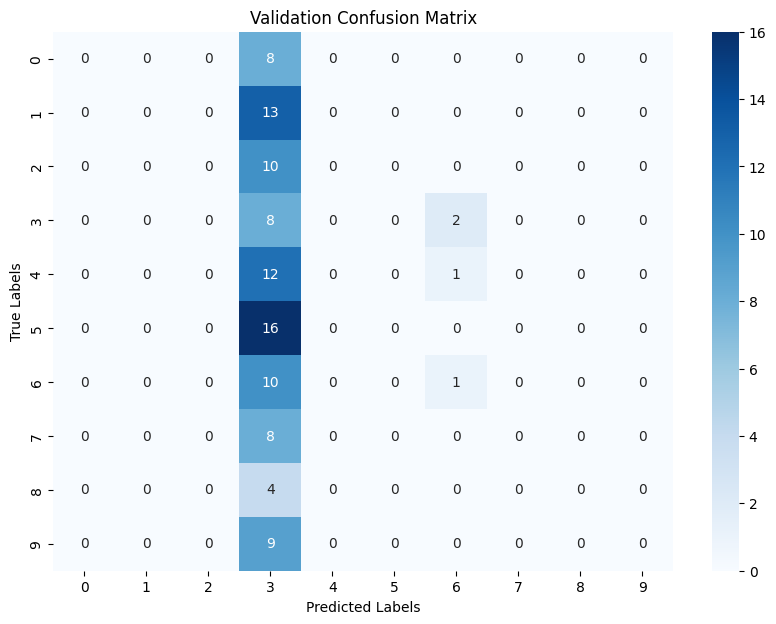

Validation loss: 2.364765570444219, Accuracy: 0.08823529411764706
END Epoch 1
Epoch 2/3


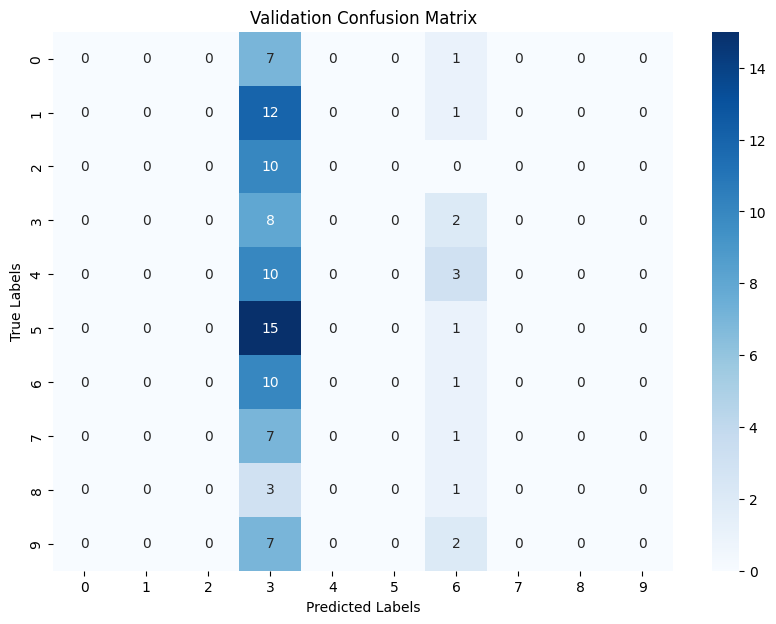

Validation loss: 2.3811995527323555, Accuracy: 0.08823529411764706
END Epoch 2
Epoch 3/3


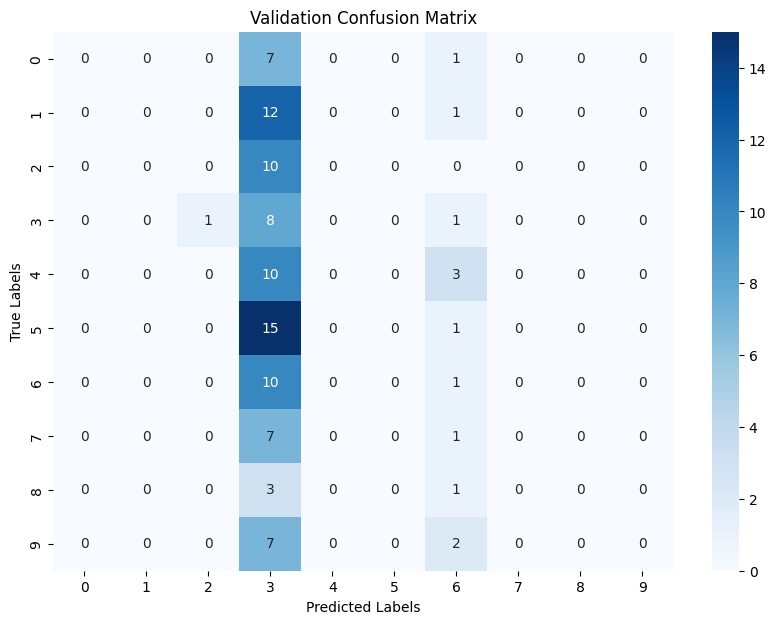

Validation loss: 2.379130885881536, Accuracy: 0.08823529411764706
END Epoch 3


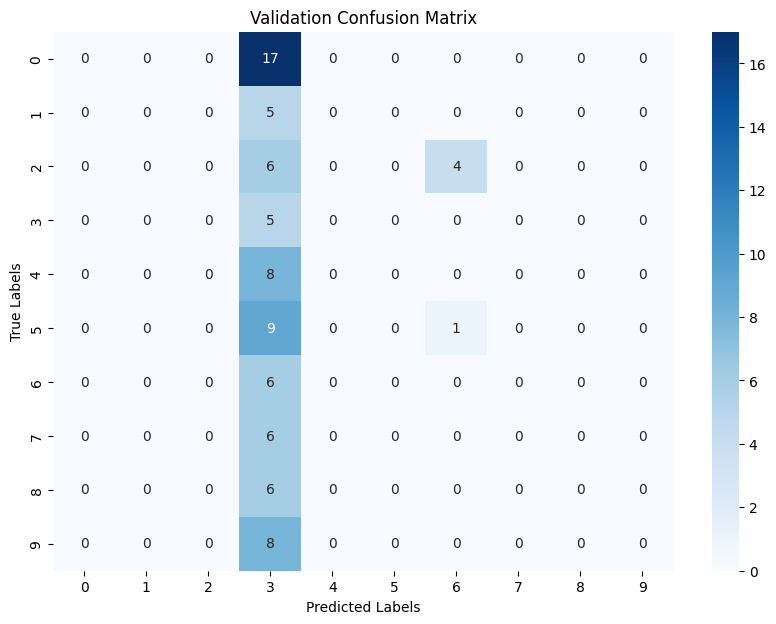

Test loss: 2.421599042268447, Accuracy: 0.06172839506172839
 - Done


In [36]:
train_rnn_model(cnn_model, rnn_model, train_data, val_data, test_data, epochs=3, batch_size=10)